# Pretrained Model Sampling

This notebook loads a pretrained model from the `models/` folder and uses it to perform the sampling demonstration.
The approach is inspired by the [Flow-Matching repository](https://github.com/dome272/Flow-Matching) but uses sample points extracted from images.

**Usage:**
- Make sure the model you wish to load (e.g. `cat_model.pt`) is present in the `models/` folder.
- Adjust the `image_file` variable if you wish to change the source image.

In [1]:
import random
import torch
import numpy as np

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

set_seed(42)

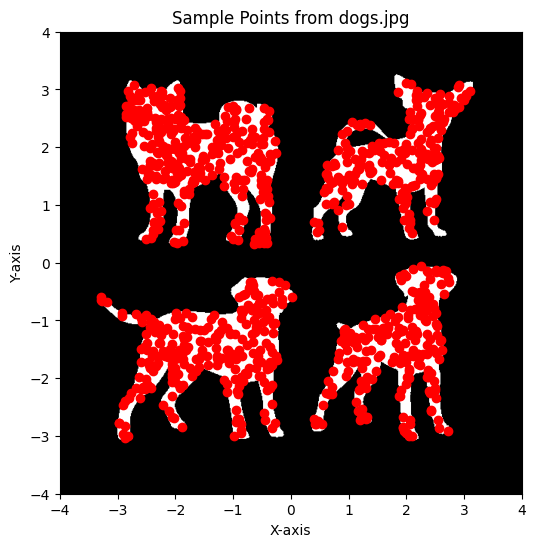

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import imageio

# --- Parameters for Data Generation ---
N = 1000  # Number of points to sample
x_min, x_max = -4, 4
y_min, y_max = -4, 4

# --- Choose Your Image ---
# Set to "cat.png" to use the dogs image; default is "dogs.jpg"
image_file = "dogs.jpg"  
img_path = os.path.join("images", image_file)

# --- Load Image ---
img = imageio.v2.imread(img_path, mode='L')
mask = img < 128  # Adjust threshold as necessary

# Get indices of the shape (where mask is True)
rows, cols = np.where(mask)
img_height, img_width = img.shape

# --- Map Pixel Coordinates to (x, y) ---
x_coords = x_min + (cols / img_width) * (x_max - x_min)
# Invert rows so that the top maps to y_max and bottom to y_min
y_coords = y_max - (rows / img_height) * (y_max - y_min)

# Combine into a 2D array of sample points
all_points = np.vstack((x_coords, y_coords)).T

# Randomly sample N points if more are available
if len(all_points) > N:
    indices = np.random.choice(len(all_points), size=N, replace=False)
    sampled_points = all_points[indices]
else:
    sampled_points = all_points

# Visualize the sampled points overlayed on the image
plt.figure(figsize=(6, 6))
plt.imshow(mask[::-1, :], extent=(x_min, x_max, y_min, y_max), origin="lower", cmap="gray")
plt.scatter(sampled_points[:, 0], sampled_points[:, 1], color="red", marker="o")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.title(f"Sample Points from {image_file}")
plt.show()

In [3]:
import math
import torch
from torch import nn

class Block(nn.Module):
    def __init__(self, channels=512):
        super().__init__()
        self.ff = nn.Linear(channels, channels)
        self.act = nn.ReLU()
    
    def forward(self, x):
        return self.act(self.ff(x))

class MLP(nn.Module):
    def __init__(self, channels_data=2, layers=5, channels=512, channels_t=512):
        super().__init__()
        self.channels_t = channels_t
        self.in_projection = nn.Linear(channels_data, channels)
        self.t_projection = nn.Linear(channels_t, channels)
        self.blocks = nn.Sequential(*[Block(channels) for _ in range(layers)])
        self.out_projection = nn.Linear(channels, channels_data)
    
    def gen_t_embedding(self, t, max_positions=10000):
        t = t * max_positions
        half_dim = self.channels_t // 2
        emb = math.log(max_positions) / (half_dim - 1)
        emb = torch.arange(half_dim, device=t.device).float().mul(-emb).exp()
        emb = t[:, None] * emb[None, :]
        emb = torch.cat([emb.sin(), emb.cos()], dim=1)
        if self.channels_t % 2 == 1:  # Zero pad if needed
            emb = nn.functional.pad(emb, (0, 1), mode='constant')
        return emb
    
    def forward(self, x, t):
        x = self.in_projection(x)
        t = self.gen_t_embedding(t)
        t = self.t_projection(t)
        x = x + t 
        x = self.blocks(x)
        x = self.out_projection(x)
        return x

In [4]:
# Instantiate the model with the same hyperparameters as used during training.
model = MLP(layers=5, channels=512)

# Specify the model file name based on the image.
model_save_name = image_file.split('.')[0] + "_model.pt"
model_save_path = os.path.join("models", model_save_name)

# Load the pretrained model's state dictionary.
model.load_state_dict(torch.load(model_save_path, map_location=torch.device('cpu')))
model.eval().requires_grad_(False)

print(f"Loaded model from {model_save_path}")

Loaded model from models/dogs_model.pt


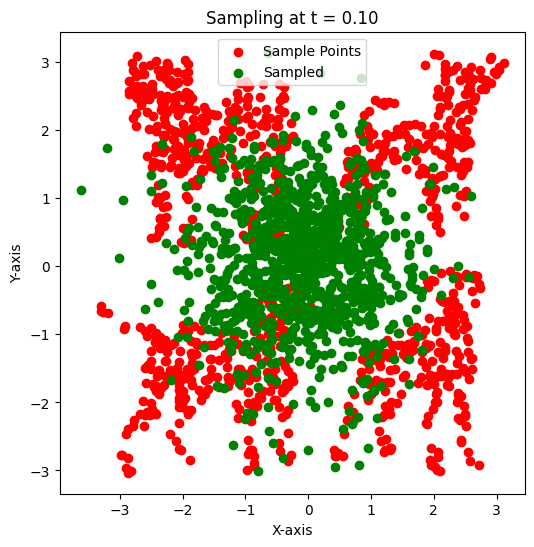

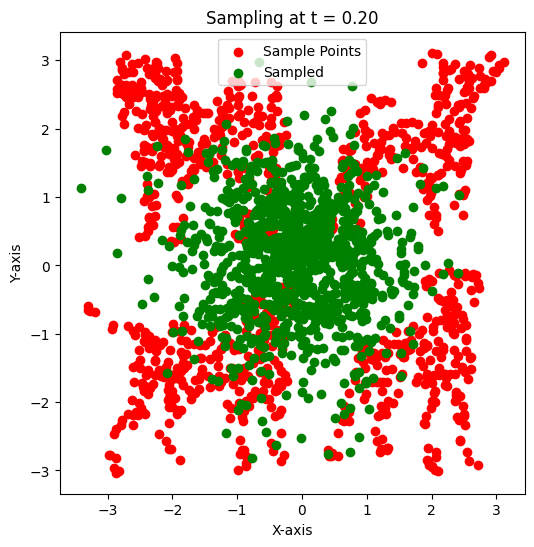

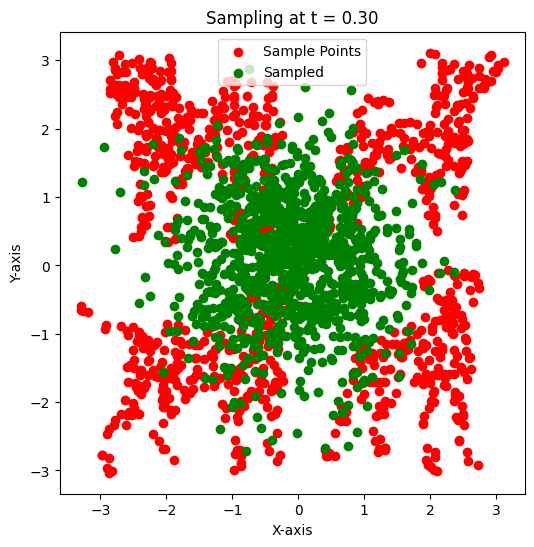

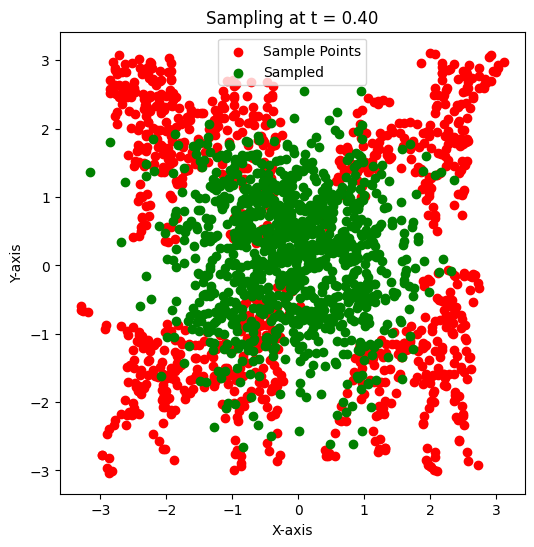

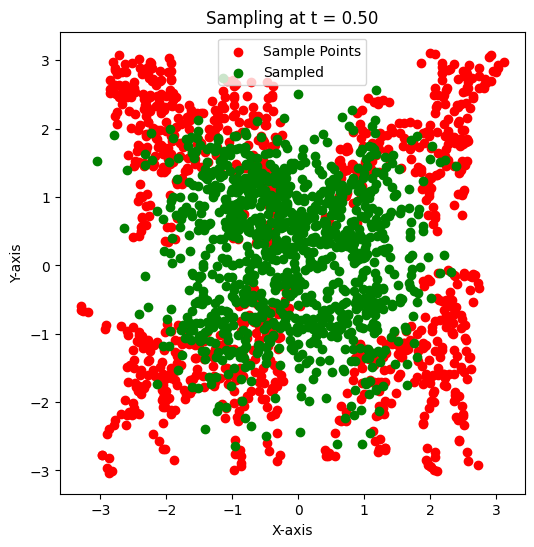

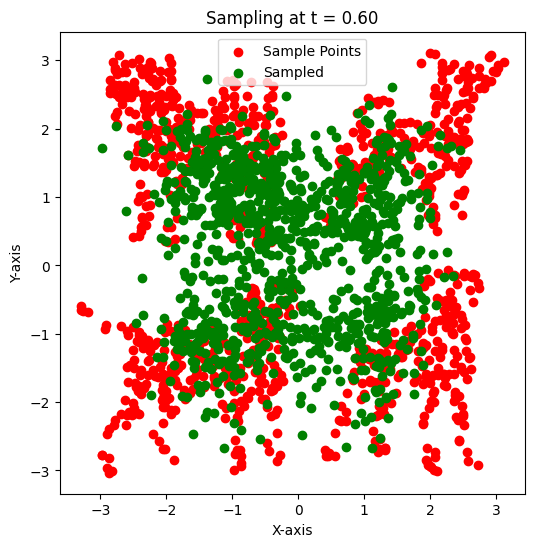

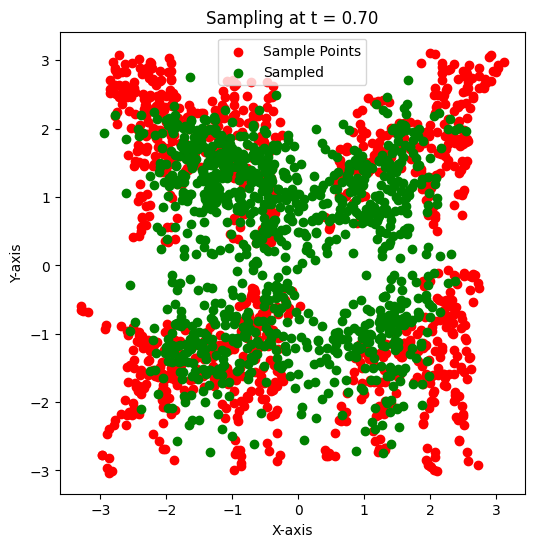

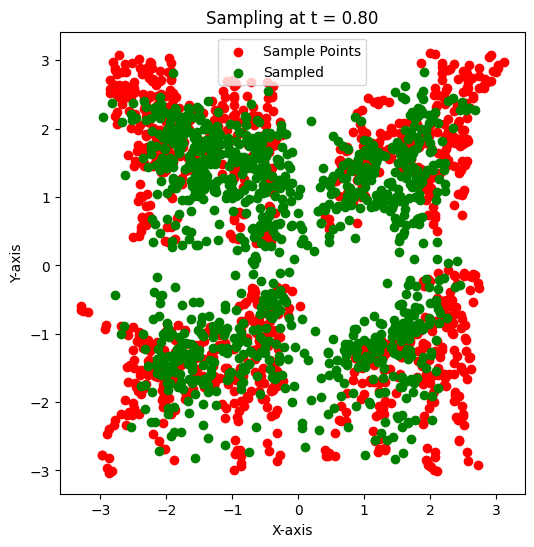

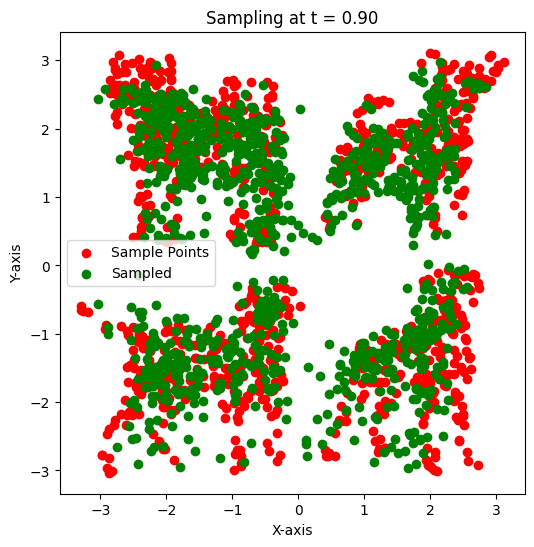

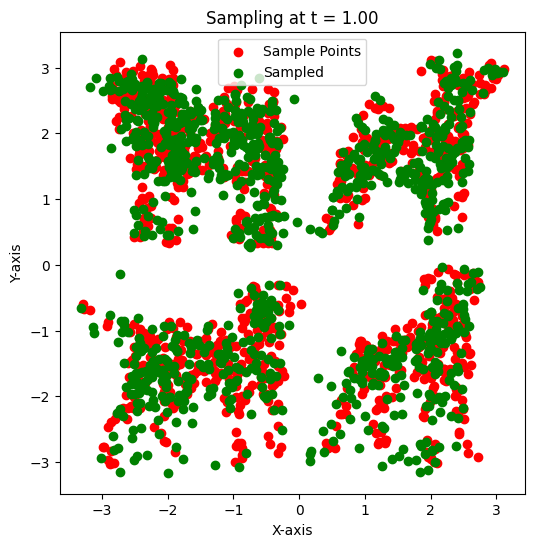

Sampling complete.


In [5]:
xt = torch.randn(1000, 2)
steps = 1000
plot_every = 100

for i, t_val in enumerate(torch.linspace(0, 1, steps), start=1):
    pred = model(xt, t_val.expand(xt.size(0)))
    xt = xt + (1 / steps) * pred
    if i % plot_every == 0:
        plt.figure(figsize=(6, 6))
        plt.scatter(sampled_points[:, 0], sampled_points[:, 1], color="red", marker="o", label="Sample Points")
        plt.scatter(xt[:, 0], xt[:, 1], color="green", marker="o", label="Sampled")
        plt.xlabel("X-axis")
        plt.ylabel("Y-axis")
        plt.title(f"Sampling at t = {t_val:.2f}")
        plt.legend()
        plt.show()

print("Sampling complete.")

819 out of 1000 generated points are inside the target area (81.90%).
Original sample points - mean nearest neighbor distance: 0.066
Generated points       - mean nearest neighbor distance: 0.077


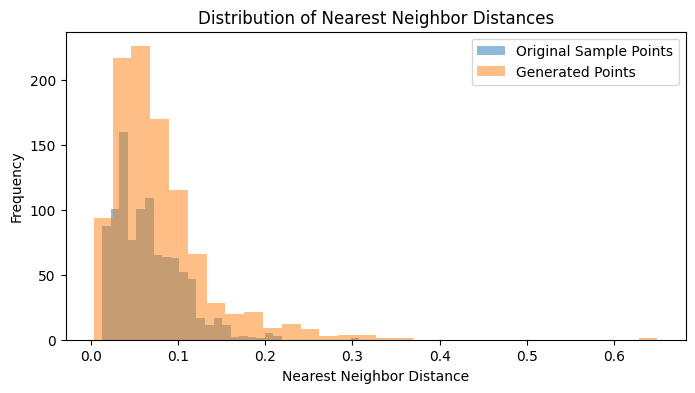

In [6]:
import numpy as np
from scipy.spatial import cKDTree

# --- Analysis Cell ---

# Convert the generated points (xt) from torch tensor to numpy array.
# (Assumes xt is the final generated points tensor from your sampling loop.)
generated_points = xt.detach().cpu().numpy()

# Function to check which points fall inside the mask.
def points_in_mask(points, mask, x_min, x_max, y_min, y_max, img_width, img_height):
    # Map each point (x, y) to pixel indices (col, row)
    cols_idx = ((points[:, 0] - x_min) / (x_max - x_min) * img_width).astype(int)
    # Since our mapping inverts rows, we compute row as:
    rows_idx = ((y_max - points[:, 1]) / (y_max - y_min) * img_height).astype(int)
    
    # Ensure indices are within valid image boundaries
    cols_idx = np.clip(cols_idx, 0, img_width - 1)
    rows_idx = np.clip(rows_idx, 0, img_height - 1)
    
    # Return a boolean array indicating which points fall inside the area (where mask is True)
    return mask[rows_idx, cols_idx]

# Using the same mask and image dimensions from earlier cell
inside_mask = points_in_mask(generated_points, mask, x_min, x_max, y_min, y_max, img_width, img_height)
num_inside = np.sum(inside_mask)
percentage_inside = num_inside / len(generated_points) * 100

print(f"{num_inside} out of {len(generated_points)} generated points are inside the target area ({percentage_inside:.2f}%).")

# --- Spacing Analysis: Nearest Neighbor Distances ---

# Compute nearest neighbor distances using KDTree.
# For the original sample points:
original_tree = cKDTree(sampled_points)
# Query each point's 2 nearest neighbors (first is itself, so take the second)
original_nn = original_tree.query(sampled_points, k=2)[0][:,1]

# For the generated points:
generated_tree = cKDTree(generated_points)
generated_nn = generated_tree.query(generated_points, k=2)[0][:,1]

# Print mean nearest neighbor distances
print(f"Original sample points - mean nearest neighbor distance: {np.mean(original_nn):.3f}")
print(f"Generated points       - mean nearest neighbor distance: {np.mean(generated_nn):.3f}")

# Plot histograms of nearest neighbor distances for comparison.
plt.figure(figsize=(8, 4))
plt.hist(original_nn, bins=30, alpha=0.5, label="Original Sample Points")
plt.hist(generated_nn, bins=30, alpha=0.5, label="Generated Points")
plt.xlabel("Nearest Neighbor Distance")
plt.ylabel("Frequency")
plt.legend()
plt.title("Distribution of Nearest Neighbor Distances")
plt.show()